In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import re
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.initializers import Constant
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from google.colab import drive
from keras.models import save_model

In [ ]:
# Specify the file path in your Google Drive
file_path_excel = '/content/drive/MyDrive/Neural Net and Deep Learning Files/train_essays.xlsx'

In [ ]:
# Read the Excel file into a DataFrame
df = pd.read_excel(file_path_excel)

print(df.head())

                                                text  generated
0  Machine learning, a subset of artificial intel...          1
1  A decision tree, a prominent machine learning ...          1
2  Education, a cornerstone of societal progress,...          1
3  Computers, the backbone of modern technology, ...          1
4  Chess, a timeless game of strategy and intelle...          1


In [ ]:
# Initialize and fit the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])

# Convert texts to sequences of integers
sequences = tokenizer.texts_to_sequences(df['text'])

# Calculate the length of each sequence
sequence_lengths = [len(seq) for seq in sequences]

# Convert sequence lengths to a Pandas Series to use its functionalities
sequence_lengths_series = pd.Series(sequence_lengths)

# Basic statistics
print("Sequence Lengths Statistics:")
print(sequence_lengths_series.describe())

# Determine an appropriate maxlen
# You might choose a value that captures a certain percentile of the data
percentile = 95  # For example, the 95th percentile
maxlen = int(sequence_lengths_series.quantile(percentile / 100))
print(f"Chosen maxlen (95th percentile): {maxlen}")

Sequence Lengths Statistics:
count    1460.000000
mean      536.306164
std       179.219445
min        36.000000
25%       431.000000
50%       515.000000
75%       628.000000
max      1364.000000
dtype: float64
Chosen maxlen (95th percentile): 859


In [ ]:
# Basic text cleaning
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespaces
    return text

df['text'] = df['text'].apply(clean_text)

# Stemming
stemmer = PorterStemmer()
df['text'] = df['text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['generated'], test_size=0.3, stratify=df['generated'])


In [ ]:
# Tokenization and padding for GloVe
glove_tokenizer = Tokenizer()
glove_tokenizer.fit_on_texts(X_train)
X_train_seq = glove_tokenizer.texts_to_sequences(X_train)
X_test_seq = glove_tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=500)
X_test_pad = pad_sequences(X_test_seq, maxlen=500)

In [ ]:
# Function to load GloVe embeddings
def load_glove_embeddings(path, word_index, embedding_dim=50):
    embeddings_index = {}
    with open(path) as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [ ]:
# Load GloVe embeddings
embedding_dim = 50  # Adjust according to your GloVe file
embedding_matrix = load_glove_embeddings('/content/drive/MyDrive/Neural Net and Deep Learning Files/glove.6B.50d.txt', glove_tokenizer.word_index, embedding_dim)

# Build GloVe + LSTM model
glove_lstm_model = Sequential()
glove_lstm_model.add(Embedding(len(glove_tokenizer.word_index) + 1,
                               embedding_dim,
                               embeddings_initializer=Constant(embedding_matrix),
                               input_length=500,
                               trainable=False))
glove_lstm_model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
glove_lstm_model.add(Dense(1, activation='sigmoid'))

glove_lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
glove_lstm_model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_split=0.2)

# Save the trained model
model_save_path = '/content/drive/MyDrive/Neural Net and Deep Learning Files/glove_lstm_model.h5'
glove_lstm_model.save(model_save_path)

# Print a message indicating that the model has been saved
print(f'The GloVe + LSTM model has been saved to {model_save_path}')

Epoch 1/5
26/26 [==============================] - 45s 2s/step - loss: 0.3147 - accuracy: 0.8813 - val_loss: 0.2514 - val_accuracy: 0.9317
Epoch 2/5
26/26 [==============================] - 38s 1s/step - loss: 0.1799 - accuracy: 0.9437 - val_loss: 0.1990 - val_accuracy: 0.9317
Epoch 3/5
26/26 [==============================] - 42s 2s/step - loss: 0.1309 - accuracy: 0.9449 - val_loss: 0.1373 - val_accuracy: 0.9415
Epoch 4/5
26/26 [==============================] - 40s 2s/step - loss: 0.0655 - accuracy: 0.9743 - val_loss: 0.0567 - val_accuracy: 0.9902
Epoch 5/5
26/26 [==============================] - 38s 1s/step - loss: 0.0364 - accuracy: 0.9939 - val_loss: 0.0521 - val_accuracy: 0.9854


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


The GloVe + LSTM model has been saved to /content/drive/MyDrive/Neural Net and Deep Learning Files/glove_lstm_model.h5


14/14 [==============================] - 2s 134ms/step
Accuracy: 0.9931506849315068
Precision: 0.8928571428571429
Recall: 1.0
F1 Score: 0.9433962264150945
AUC-ROC Score: 0.9963680387409202


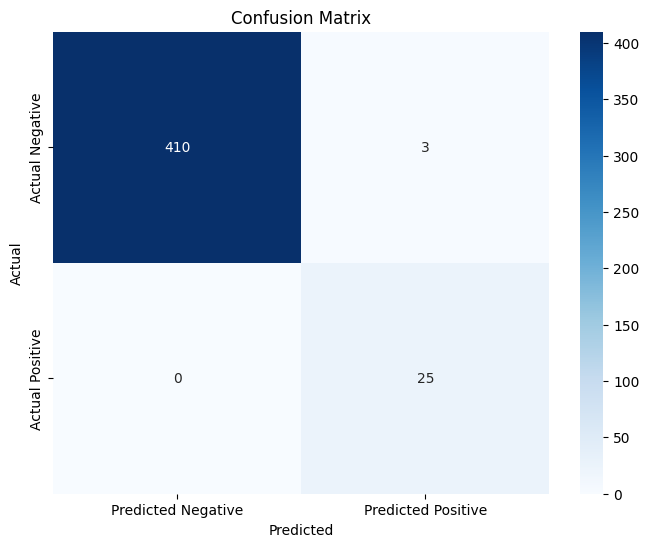

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    predictions = [1 if p > 0.5 else 0 for p in predictions]

    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    auc_roc = roc_auc_score(y_test, predictions)

    # Confusion matrix
    cm = confusion_matrix(y_test, predictions)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUC-ROC Score: {auc_roc}")

    # Display confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Assuming you have imported roc_curve, auc, seaborn, and matplotlib.pyplot
evaluate_model(glove_lstm_model, X_test_pad, y_test)
